# Transfer Learning
## Feature Extraction

We've already built some convolutional neural networks from scratch and they all seemed to be working. However, there is still of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and so on.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another (similar) problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with much less data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

### Check if we have a GPU

To begin, let's check to see if we're using a GPU.


In [1]:
!nvidia-smi

Tue Nov  4 11:35:56 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:41:00.0 Off |                    0 |
|  0%   37C    P0              70W / 300W |      4MiB / 46068MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Transfer leanring with kaggle

For many of the problems you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on [Hugging Face](https://huggingface.co/) or [kaggle](https://www.kaggle.com/models) or many other platforms.

Kaggle is a repository for existing model components and datasets. You can import and use a fully trained model with as little as a URL.

To demonstrate the power of transfer learning, we will work on a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
The original dataset consists images belonging to 101 food classes. However, we will only be using 10 food classes. What is more, we won't be using all 7500 training images, but only 10% of these.

Wouldn't more pictures of food lead to better results? Generally speaking, yes. However, what if you didn't have that many images available? It would take a lot of effort to collect and label these. Not only that, but training a model from scratch on a vast amount of data is computationally expensive and, quite frankly, a waste of resources.

So this is where another major benefit of transfer learning comes in.

**Transfer learning often allows you to get great results with less data.**

<img src="images/transfer-learning-feature-extraction.png" width="80%">



### Downloading and inspecting the data

## Get data (10% of labels)
import zipfile

## Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

## Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("./data/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in './data/10_food_classes_10_percent'.
There are 10 directories and 0 images in './data/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in './data/10_food_classes_10_percent/train/hamburger'.

Notice how each of the training directories only has 75 images rather than the full 750 images, which is less than what the test directories have. Usually, this would not make a lot of sense, but in our case we want to demonstrate how powerful transfer learning can be.

### Data loaders to prepare data

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "./data/10_food_classes_10_percent/train/"
test_dir = "./data/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

2025-11-04 11:35:57.350467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-04 11:35:57.350537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-04 11:35:57.351378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-04 11:35:57.358298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

### Creating models using kaggle

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [kaggle](https://www.kaggle.com/models).

In fact, we're going to use two models from kaggle:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.


You can see a list of state of the art models on [paperswithcode.com](https://www.paperswithcode.com), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the [models which perform best on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet).


> **Question:** *Should we use feature vector or classification?*

Good question. There are different types of transfer learning that come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes. 

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class). 

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. 

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. 

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

<img src="images/different-kinds-of-transfer-learning.png" width="80%">

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Now we'll get the feature vector URLs of two common computer vision architectures from the kaggle website.

We're getting both of these because we're going to compare them to see which performs better on our data.

In [5]:
#!pip show tensorflow_hub

In [6]:
# import pkg_resources

In [7]:
# pkg_resources.require("tensorflow_hub==0.15.0")
# import tensorflow_hub

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/1"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

# # New: EfficientNetB0 feature vector (version 2) However, in this example version 1 outperforms version 2
# efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2"

These URLs link to a saved pretrained model on kaggle.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [9]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub or kaggle URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub or kaggle feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

Once the model is instantiated, we'll compile it using `categorical_crossentropy` as our loss function, the Adam optimizer and accuracy as our metric.

In [10]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

2025-11-04 11:36:08.948707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43604 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


<img src="images/resnet-feature-extractor.png">

This is what our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes).

**Note:** The Image shows ResNet34 instead of ResNet50.

**Image source:** https://arxiv.org/abs/1512.03385.

It's time to fit the model.
We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

Let's keep this experiment short and train for 5 epochs.

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5


2025-11-04 11:36:13.162521: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-04 11:36:14.061716: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6a61735580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-04 11:36:14.061768: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-11-04 11:36:14.067847: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762252574.198915 1922588 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 10s 281ms/step - loss: 1.8913 - accuracy: 0.3587 - val_loss: 1.2284 - val_accuracy: 0.5916
Epoch 2/5
24/24 [==============================] - 6s 236ms/step - loss: 0.9161 - accuracy: 0.7267 - val_loss: 0.8589 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 5s 232ms/step - loss: 0.6239 - accuracy: 0.8387 - val_loss: 0.7786 - val_accuracy: 0.7404
Epoch 4/5
24/24 [==============================] - 5s 231ms/step - loss: 0.4758 - accuracy: 0.8827 - val_loss: 0.7065 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 5s 231ms/step - loss: 0.3770 - accuracy: 0.9187 - val_loss: 0.6755 - val_accuracy: 0.7768


That's quite impressive!
It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set with a very limited training dataset.

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's visualize the model's training curves after creating a `plot_loss_curves` function.

In [12]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

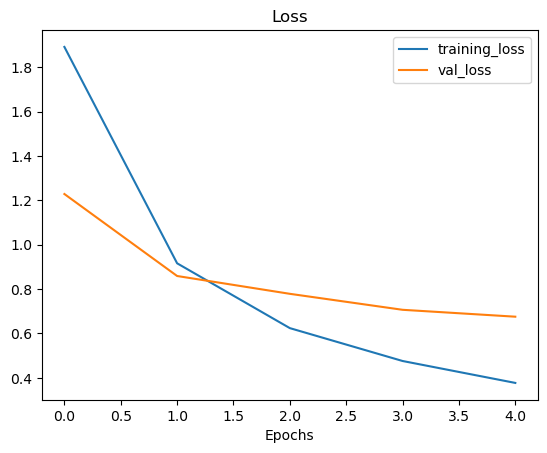

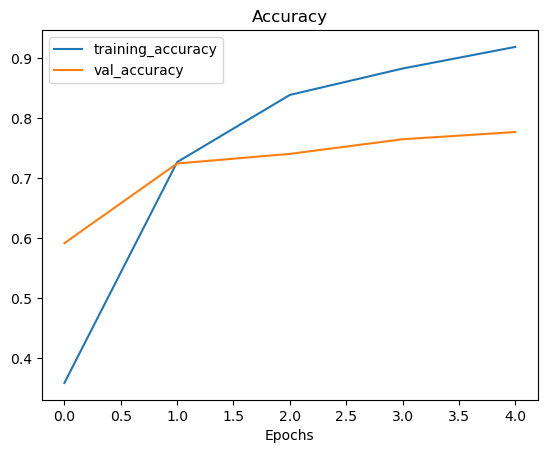

In [13]:
plot_loss_curves(resnet_history)

Let's have a look at the summary of our model:

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Now that we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the `model_url` parameter in the `create_model()` function.

It is your turn to create, compile and fit the efficientnet_model:

#### Solution:

In [15]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 12s 263ms/step - loss: 1.8104 - accuracy: 0.4307 - val_loss: 1.2725 - val_accuracy: 0.7300
Epoch 2/5
24/24 [==============================] - 5s 231ms/step - loss: 1.0422 - accuracy: 0.7733 - val_loss: 0.8603 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 5s 229ms/step - loss: 0.7464 - accuracy: 0.8520 - val_loss: 0.6994 - val_accuracy: 0.8324
Epoch 4/5
24/24 [==============================] - 5s 233ms/step - loss: 0.5998 - accuracy: 0.8840 - val_loss: 0.6078 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 5s 234ms/step - loss: 0.5055 - accuracy: 0.9000 - val_loss: 0.5568 - val_accuracy: 0.8572


It seems the EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's visualize out the loss curves.

#### Loss curves

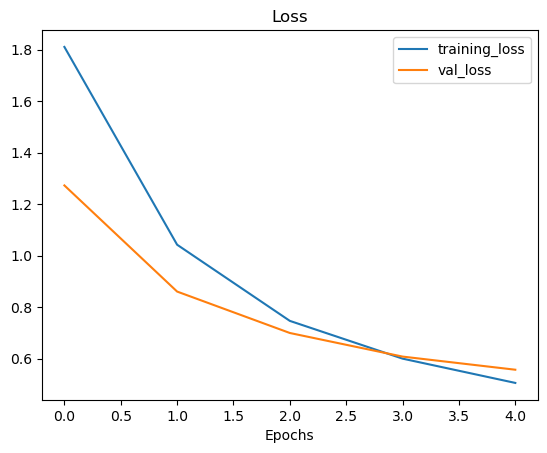

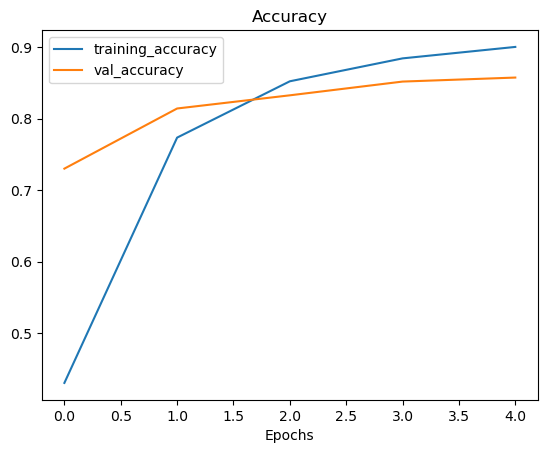

In [16]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further...

Now, for the model summary.

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


It seems despite having over four times less parameters (4,049,564 vs. 23,564,800) than the ResNet50V2 extraction layer, the  EfficientNetB0 feature extraction layer yields better performance. Now it's clear where the "efficient" name came from :-)

## Data augmentation

Data augmentation is a way to increase the size of our dataset artificially by changing the existing data slightly in predefined ways. In case of images this might mean slight rotation, zooming, panning, etc.
We are goining to build the data augmentation steps right into the model.

To do that we will use the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module and creating a dedicated data augmentation layer.

This a relatively new and powerful feature in TensorFlow. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU.
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model (a Keras API we have not used before).

The data augmentation transformations we're going to use are:
* [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) - flips image on horizontal or vertical axis.
* [`tf.keras.layersRandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) - randomly rotates image by a specified amount.
* [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) - randomly zooms into an image by specified amount.
* [`tf.keras.layers.RandomHeight`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight) - randomly shifts image height by a specified amount.
* [`tf.keras.layers.RandomWidth`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth) - randomly shifts image width by a specified amount.
* [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0), it's not required (the model pretrained model implements rescaling itself).

There are more option but these will do for now.

First we need to load our data again, this time without the rescaling.

In [18]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)


# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # This is another way to get hold of the base model
#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# What you will see now, is Keras' functional API
# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # this layer is needed to transform the 4D output from the basemodel into a 2D input for the dense layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
efficientnet_model_augm = tf.keras.Model(inputs, outputs)

# Compile
efficientnet_model_augm.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

16705208/16705208 [==============================] - 2s 0us/step


To save time for later, let's put the code above into a function we can resuse.

In [20]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
efficientnet_model_augm = create_base_model()

24274472/24274472 [==============================] - 2s 0us/step


In [21]:
# Fit the model
initial_epochs = 5
history_efficientnet_data_aug = efficientnet_model_augm.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data))) # do less steps per validation (quicker)

Epoch 1/5
24/24 [==============================] - 17s 524ms/step - loss: 2.0532 - accuracy: 0.3280 - val_loss: 1.5153 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - 12s 483ms/step - loss: 1.4294 - accuracy: 0.6480 - val_loss: 1.1167 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - 11s 462ms/step - loss: 1.1127 - accuracy: 0.7467 - val_loss: 0.8458 - val_accuracy: 0.8092
Epoch 4/5
24/24 [==============================] - 10s 404ms/step - loss: 0.9550 - accuracy: 0.7707 - val_loss: 0.7525 - val_accuracy: 0.8224
Epoch 5/5
24/24 [==============================] - 10s 400ms/step - loss: 0.8263 - accuracy: 0.7880 - val_loss: 0.6572 - val_accuracy: 0.8372


In [22]:
efficientnet_model_augm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

How did our model perform?

Let's evaluate our model and check its loss curves.

In [23]:
# Evaluate on the test data
results_10_percent_data_aug = efficientnet_model_augm.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 2s 24ms/step - loss: 0.6656 - accuracy: 0.8220


[0.6656075119972229, 0.8220000267028809]

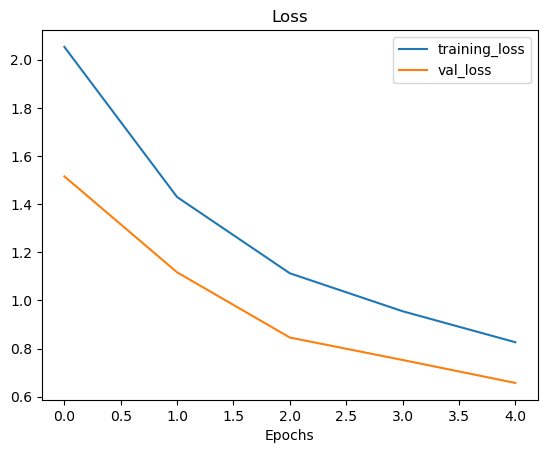

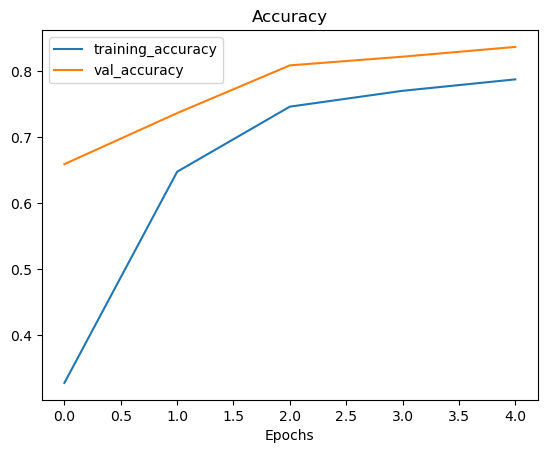

In [24]:
# Plot model loss curves
plot_loss_curves(history_efficientnet_data_aug)

Judging by the curves, we could try training our model for longer...

## Fine-tuning an existing model

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetB0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

In [25]:
# Layers in loaded model
efficientnet_model_augm.layers

How about we check their names, numbers and if they're trainable?

In [26]:
for layer_number, layer in enumerate(efficientnet_model_augm.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7f6b9c262c80> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7f5f238d18a0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7f5f21475720> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f5f2209a350> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7f5f2213a590> | Trainable? True


Looking good.

We've got an input layer, a Sequential layer (the data augmentation model), a Functional layer (EfficientNetB0), a pooling layer and a Dense layer (the output layer).

How about a summary?

In [27]:
efficientnet_model_augm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

Alright, it looks like all of the layers in the `efficientnet-b0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

In [28]:
# Access the base_model layers of model_2
model_2_base_model = efficientnet_model_augm.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [29]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


We can even check layer by layer to see if the they're trainable.

To access the layers in `model_2_base_model`, we can use the `layers` attribute.

In [30]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Now, to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

To begin fine-tuning, we'll unfreeze the entire `model_2_base_model` by setting its `trainable` attribute to `True`.

Then we'll refreeze every layer in `model_2_base_model` except for the last 10 by looping through them and setting their `trainable` attribute to `False`.

Finally, we'll recompile the whole model.

In [31]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
efficientnet_model_augm.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

Let's see which layers of the pretrained model are trainable.

In [32]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

That was just what we wanted. It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. We'll pass it the last epoch of the previous model's training history (`history_efficientnet_data_aug.epoch[-1]`).

In [33]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_efficientnet_data_aug = efficientnet_model_augm.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_efficientnet_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
24/24 [==============================] - 33s 1s/step - loss: 0.7204 - accuracy: 0.8160 - val_loss: 0.5393 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 21s 873ms/step - loss: 0.5862 - accuracy: 0.8360 - val_loss: 0.5142 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - 15s 612ms/step - loss: 0.5485 - accuracy: 0.8280 - val_loss: 0.5020 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 18s 721ms/step - loss: 0.5143 - accuracy: 0.8333 - val_loss: 0.4772 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 16s 677ms/step - loss: 0.4846 - accuracy: 0.8493 - val_loss: 0.4689 - val_accuracy: 0.8438
Epoch 10/10
24/24 [==============================] - 13s 554ms/step - loss: 0.4641 - accuracy: 0.8480 - val_loss: 0.4373 - val_accuracy: 0.8553


**Note:** Fine-tuning usually takes far longer per epoch than feature extraction (due to updating more weights throughout a network).

Looks like our model has gained a few percentage points of accuracy! Let's evalaute it.

In [34]:
# Evaluate the model on the test data
results_fine_tune_10_percent = efficientnet_model_augm.evaluate(test_data)

79/79 [==============================] - 2s 21ms/step - loss: 0.4432 - accuracy: 0.8504


This is our best result so far.